In [2]:
from os import listdir
from os.path import isfile
from fnmatch import fnmatch
from math import isnan, ceil
from pprint import pprint
from statistics import median
from re import match

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [3]:
def get_ratio(filename):
    return filename.split('_')[0].replace('ratio','')

In [4]:
def get_run(filename):
    return int(filename.split('_')[1].replace('run',''))

In [5]:
def get_vcs(filename):
    return int(filename.split('_')[2].replace('vclients',''))

In [6]:
def get_client(filename):
    return int(filename.split('_')[3].replace('client', ''))

In [7]:
def get_instance(filename):
    return int(filename.split('_')[-1].replace('instance','').replace('.log', ''))

In [8]:
def roundup(x):
    return int(ceil(x / 1.0)) * 1

In [9]:
def get_avg_rt(df, ratios, vclients, runs, threads, instances, clients):
    rts = []
    stds = []
    ils = []
    xs = [x * threads * instances * clients for x in vclients] 
    for ratio in ratios:
        values = [.0] * len(vclients)
        std = [.0] * len(vclients)
        il = [.0] * len(vclients)
        fig, ax = plt.subplots()
        for i, vc in enumerate(vclients):
            values[i] = df.unstack().loc[(ratio, vc), 'RT'].T.mean().unstack().T.mean().mean()
            std[i] = np.std(df.unstack().loc[(ratio, vc), 'RT'].T.mean().unstack().T.mean().mean())
            il[i] = 1000 / values[i] * (vc * threads * instances * clients)
        plt.errorbar(xs , values, std, label='AVG of %d reps[stdev]' % max(runs), capsize=3)
        ax.set_xlim(xmin=0, xmax=max(xs))
        plt.ylim(0, roundup(max(values) / 10) * 10 + max(std))
        plt.xticks(xs)
        plt.xlabel('Virtual Clients')
        plt.ylabel('Response Time (msec)')
        plt.legend(loc='lower right')
        plt.grid(b=True, which='major', axis='both', color='0.6', linestyle='dotted')
        rts.append(values)    
        stds.append(std)
        ils.append(il)
    return rts, stds, ils

In [10]:
def get_avg_tp(df, ratios, vclients, runs, ils, threads, instances, clients):
    tps = []
    stds = []
    xs = [x * threads * instances * clients for x in vclients] 
    for j, ratio in enumerate(ratios):
        values = [.0] * len(vclients)
        std = [.0] * len(vclients)
        fig, ax = plt.subplots()
        for i, vc in enumerate(vclients):
            values[i] = df.unstack().loc[(ratio, vc), 'TP'].T.sum().unstack().T.sum().mean()
            std[i] = np.std(df.unstack().loc[(ratio, vc), 'TP'].T.sum().unstack().T.sum())
        plt.errorbar(xs, values, std, label='AVG of %d reps[stdev]' % max(runs), capsize=3, fmt='--')
        plt.plot(xs, ils[j], label='Interactive Law')
        ax.set_xlim(xmin=0, xmax=max(xs))
        print(max(std))
        print(values)
        print(median(values))
        print(roundup(max(values)))
        plt.ylim(0, int(max(values) + 500))
        plt.xticks(xs)
        plt.xlabel('Virtual Clients')
        plt.ylabel('Throughput (Ops/sec)')
        plt.legend(loc='lower right')
        plt.grid(b=True, which='major', axis='both', color='0.6', linestyle='dotted')
        k_formatter = lambda v, p: str(float(v / 1000)) + 'k'
        ax.yaxis.set_major_formatter(ticker.FuncFormatter(k_formatter))
        tps.append(values)
        stds.append(std)
    return tps, stds

                                    TP     RT  25th  50th  75th  90th  99th
ratio VCs run client instance                                              
0:1   1   1   1      1          809.92   2.46   0.0   0.0   0.0   0.0   0.0
              2      1          960.43   2.08   0.0   0.0   0.0   0.0   0.0
              3      1          964.86   2.06   0.0   0.0   0.0   0.0   0.0
          2   1      1          845.20   2.35   0.0   0.0   0.0   0.0   0.0
              2      1         1010.55   1.97   0.0   0.0   0.0   0.0   0.0
              3      1         1021.70   1.95   0.0   0.0   0.0   0.0   0.0
          3   1      1          795.93   2.50   0.0   0.0   0.0   0.0   0.0
              2      1          928.73   2.14   0.0   0.0   0.0   0.0   0.0
              3      1          950.18   2.10   0.0   0.0   0.0   0.0   0.0
      4   1   1      1          918.21   8.70   0.0   0.0   0.0   0.0   0.0
              2      1         1015.34   7.87   0.0   0.0   0.0   0.0   0.0
            

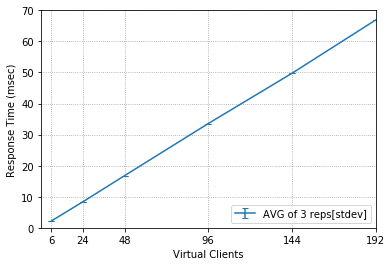

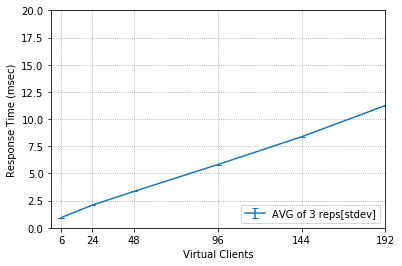

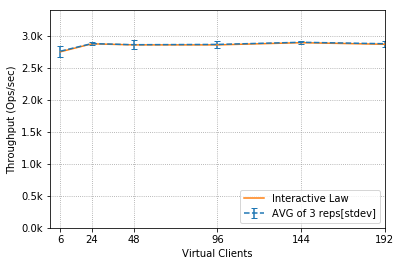

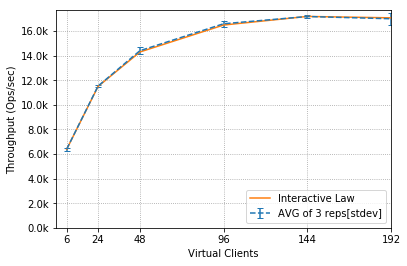

In [16]:
timestamp = '20181120233828'
log_dir = 'logs/%s/' % timestamp

logs = [f for f in listdir(log_dir) if fnmatch(f, '*.log')]

ratios = ['0:1', '1:0']
runs = [x for x in range(1, 3 + 1)] 
instances = [x for x in range(1, 1 + 1)]
threads = 2
clients = [x for x in range(1, 3 + 1)]
vclients = [1, 4, 8, 16, 24, 32]

multi_index = [ratios, vclients, runs, clients, instances]
len_index = len(ratios) * len(vclients) * len(runs) * len(clients) * len(instances)

index = pd.MultiIndex.from_product(multi_index, names=['ratio', 'VCs', 'run', 'client', 'instance'])
columns = ['TP', 'RT', '25th', '50th', '75th', '90th', '99th']
pd.set_option("display.precision", 2)
template = pd.DataFrame([[.0] * len(columns)] * len_index, index=index, columns=columns)


for log_file in logs: 

    ratio = get_ratio(log_file) 
    run = get_run(log_file)
    vcs = get_vcs(log_file)
    client = get_client(log_file)
    instance = get_instance(log_file)

    df = pd.read_csv(log_dir+log_file, chunksize=1, header=None, encoding='utf-8')

    table_offset = 0
    i=0
    with (open(log_dir+log_file, 'r')) as file:
        
        patterns = ['ALL STATS', 'Request Latency Distribution']
        offsets = [0, 0]
        pattern = patterns[0]
        offset = offsets[0]

        lines = file.readlines()
        for line in lines:
            if "100%" in line:
                TOTAL = int(line.split(',')[2].strip().split()[2].replace(')','')) * 70
            line = line.strip()
            i+=1
            if line != pattern:
                offset += 1
            elif pattern == patterns[0]:
                pattern = patterns[1]
                offsets[0] = offset
                offset = offsets[1]
            else:
                offsets[1] = offset + offsets[0]
                break
                
    table_offset = offsets[0]
    histo_offset = offsets[1]

    table = pd.read_table(log_dir+log_file,  skiprows=table_offset+4, nrows=4, skipinitialspace=True, delim_whitespace=True, na_values='---', index_col=0, dtype={'Type': object, 'Ops/sec': np.float32, 'Hits/sec': np.float32, 'Misses/sec': np.float32, 'Latency': np.float32, 'KB/sec': np.float32}, names=['Type', 'Ops/sec', 'Hits/sec', 'Misses/sec', 'Latency', 'KB/sec'])
    
    template.loc[(ratio, vcs, run, client, instance), 'TP'] = table['Ops/sec']['Totals']
    template.loc[(ratio, vcs, run, client, instance), 'RT'] = table['Latency']['Totals']

print(template)
rts, stds, ils = get_avg_rt(template, ratios, vclients, runs, threads, len(instances), len(clients))
tps, stds = get_avg_tp(template, ratios, vclients, runs, ils, threads, len(instances), len(clients))
    